# II. Camera localization - Rotational and Translational errors

In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import time
from google.colab import drive
# drive.mount('/content/drive')
%cd /content/drive/MyDrive/ANAIS2023-PoseNet-Lab
from pose_resnet import *
from utils import *

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-e4d7ba083800>", line 7, in <cell line: 7>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/ANAIS2023-PoseNet-Lab')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/

## 2. Download dataset

In [ ]:
# Specify the URL of the file to download
url = "https://api.repository.cam.ac.uk/server/api/core/bitstreams/1cd2b04b-ada9-4841-8023-8207f1f3519b/content"

# Specify the destination file path
file_path = 'KingsCollege.zip'

# Check if the file already exists
if not os.path.exists(file_path):
    # Download the file
    response = requests.get(url, stream=True)
    file_size = int(response.headers.get('Content-Length', 0))
    chunk_size = 1024
    num_bars = int(file_size / chunk_size)
    
    with open(file_path, 'wb') as f:
        for chunk in tqdm(response.iter_content(chunk_size=chunk_size), total=num_bars, unit='KB', desc='Downloading File', ascii=True, ncols=75):
            f.write(chunk)
    !unzip /content/KingsCollege.zip -d /content/
else:
    print(f"File '{file_path}' already exists. Skipping download.")
  
# Extract the zip file
# !unzip /content/KingsCollege.zip -d /content/

## 3. Define the rotational error

In [31]:
def compute_rotational_error(q1,q2):
    """
    Compute the rotational error between two quaternions.

    Inputs:
    - q1: Quaternion 1 (torch.Tensor)
    - q2: Quaternion 2 (torch.Tensor)

    Output:
    - rot_error: Rotational error in degrees (float)
    """
    # TODO
    q1=q1/np.linalg.norm(q1)
    q2=q2/np.linalg.norm(q2)   
    R1=quaternion_to_rotation_matrix(q1)
    R2=quaternion_to_rotation_matrix(q2)
    R=R1.T@R2
    return np.rad2deg(math.acos(0.5*(np.trace(R)-1)))    

## 4. Define the translational error

In [ ]:
def compute_translational_error(t1,t2):
    """
    Compute the translational error between two translation vectors.

    Inputs:
    - t1: Translation vector 1 (torch.Tensor)
    - t2: Translation vector 2 (torch.Tensor)

    Output:
    - trans_error: Translational error (float)
    """
    # TODO
    return math.sqrt(sum((t1-t2)**2))

## 5. Main

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inference speed: 0.004432 seconds
the rotational error is 5.44 degrees, 
           the translational error is 0.68 meters


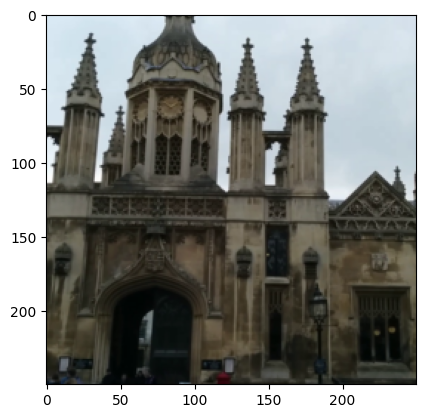

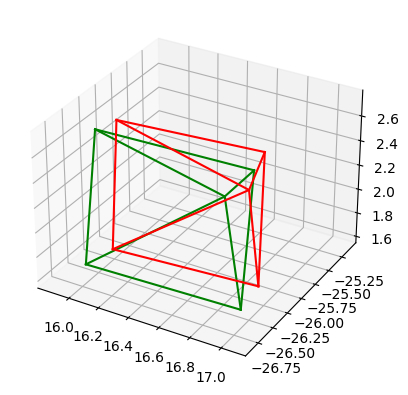

In [32]:
def main():
    # load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = PoseResNet().to(device)
    model.load_state_dict(torch.load("posenet_weigths.pth", map_location=device))
    model.eval().to(device)

    # Load the image
    root_dir = "/content/drive/MyDrive/ANAIS2023-PoseNet-Lab/KingsCollege/"
    image_number = 54  # Define the image number you want to test
    image, pose = load_single_image_and_pose(root_dir, root_dir + "dataset_test.txt", image_number)
    
    # Run the model on the image
    model.eval()
    image = image.to(device)
    pose = pose.to(device)
    start_time = time.time()
    output = model(image)
    end_time = time.time()
    speed = (end_time - start_time)
    print("Inference speed: {:.6f} seconds".format(speed))

    # Compute the rotational and translational error
    pred_pose = output.detach().cpu().numpy()[0]
    gt_pose = pose.detach().cpu().numpy()[0]
    q_pred, t_pred = pred_pose[3:7], pred_pose[:3]
    q_gt, t_gt = gt_pose[3:7], gt_pose[:3]
    err_rot = compute_rotational_error(q_pred,q_gt)
    err_trans = compute_translational_error(t_pred,t_gt)
    print("the rotational error is {:.2f} degrees, \n \
          the translational error is {:.2f} meters"\
          .format(err_rot, err_trans))

    # Plot the image and frustums
    plot_image_n(image)
    plot_cameras_pred_gt(gt_pose, pred_pose)

if __name__ == "__main__":
    main()